In [1]:
%load_ext autotime
RANDOM_STATE = 42

In [2]:
!pip install tweet-preprocessor

time: 1.5 s


## Packages

In [3]:
import os
import csv
import json
import string
import random
import numpy as np
import pandas as pd
from os.path import abspath, join
from sklearn.model_selection import train_test_split
from preprocessor import preprocess

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, Bidirectional, GlobalAveragePooling3D, Dropout, GRU, Conv1D, SpatialDropout1D, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2, l1, l2
from sklearn.metrics import classification_report, precision_score, f1_score, accuracy_score, recall_score
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

time: 2.3 s


## Dataset Loading

In [4]:
folder_name = "".join(random.choice(string.ascii_letters) for i in range(10))
folder_path = abspath(folder_name)
print(folder_path)
os.makedirs(folder_path)

/home/anjir29/Desktop/Covid_Vaccine_Sentiment/lstm_nb/mTkTwfrKNp
time: 1.13 ms


In [5]:
dataset = pd.read_csv(abspath('./data.csv'))
dataset['Sentiment'] = dataset['Sentiment']
dataset['target'] = dataset['outcome'] == 'Yes'
dataset.sample(10)

,Timestamp,Gender,Age,Did you take COVID 19 vaccine?,outcome,Sentiment,target
1221,2021/03/09 2:11:24 PM GMT+6,Male,20-40,No,Yes,I believe that by taking vaccines we can prote...,True
131,2/16/2021 14:40:43,Female,20-40,No,No,If 80% of the population feels no symptoms fro...,False
1211,2021/03/09 12:57:34 PM GMT+6,Female,20-40,No,Yes,COVID-19 vaccination is a safer way to help bu...,True
785,2021/02/26 3:39:17 PM GMT+6,Male,0-20,No,No,because vaccines are not fully appropriate or ...,False
218,2/16/2021 18:43:49,Male,20-40,No,Yes,I haven't taken Covid Vaccine but I really sup...,True
1363,2021/03/28 2:02:18 PM GMT+6,Female,60-80,Yes,No,Vaccine generates low pressure.,False
1257,2021/03/26 9:41:09 AM GMT+6,Female,20-40,No,No,I don't believe in Covid 19 vaccine as the res...,False
284,2/22/2021 14:58:30,Male,20-40,No,Yes,At present this vaccine increases the immunity...,True
409,2/28/2021 12:17:07,Female,0-20,No,No,The flu vaccine doesn’t protect against all st...,False
632,2021/02/22 11:18:08 AM GMT+6,Male,0-20,No,No,Covid Vaccine isn't properly tested as the bes...,False


time: 125 ms


## Dataset Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Sentiment'], dataset['target'], test_size=0.2, random_state=RANDOM_STATE)

time: 48.4 ms


In [7]:
X_train.head(5)

1335    Bangladesh kicked off its coronavirus vaccinat...
579     I can't risk my closed ones' lives to experiment.
1137    No comments on the bad sides. Focus on the bri...
48         I don't trust doctors. We don't need vaccines.
155     If you list any cause of death as Covid are Co...
Name: Sentiment, dtype: object

time: 67.6 ms


In [8]:
y_train.head(5)

1335    False
579     False
1137     True
48      False
155     False
Name: target, dtype: bool

time: 79.5 ms


## Model Config

In [9]:
model_metrices =['accuracy']
batch_size = 64
embedding_dimensions = 16
loss_function = BinaryCrossentropy()
max_sequence_length = 280
num_distinct_words = 2**20
optimizer = Adam()
validation_split = 0.2

time: 70 ms


In [10]:
tokenizer = Tokenizer(num_words=num_distinct_words)
tokenizer.fit_on_texts(X_train)

time: 99.4 ms


In [11]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

time: 74.6 ms


In [12]:
padded_X_train = pad_sequences(X_train, maxlen=max_sequence_length, value=0) # 0.0 because it corresponds with <PAD>
padded_X_test = pad_sequences(X_test, maxlen=max_sequence_length, value=0)

time: 75 ms


## Model Layers

#### Just Change GRU to SimpleRNN to generate SimpleRnn results

In [13]:
input = Input(shape=(max_sequence_length))
layers = Embedding(num_distinct_words, embedding_dimensions, input_length=max_sequence_length)(input)
# layers = Conv1D(8, 16)(layers)
# layers = SpatialDropout1D(0.20)(layers)
layers = GRU(32, dropout=0.20)(layers)
# layers = Dropout(0.20)(layers)
# layers = LSTM(32, dropout=0.2)(layers)
# layers = Dense(16, activation='tanh')(layers)
output = Dense(1, activation='sigmoid',
    # kernel_regularizer=l1_l2(), bias_regularizer=l2(), activity_regularizer=l2()
)(layers)

time: 991 ms


In [14]:
model = Model(inputs=input, outputs=output)
model.compile(optimizer=optimizer, loss=loss_function, metrics=model_metrices)

time: 24.3 ms


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 280)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 280, 16)           16777216  
_________________________________________________________________
gru (GRU)                    (None, 32)                4800      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,782,049
Trainable params: 16,782,049
Non-trainable params: 0
_________________________________________________________________
time: 64.9 ms


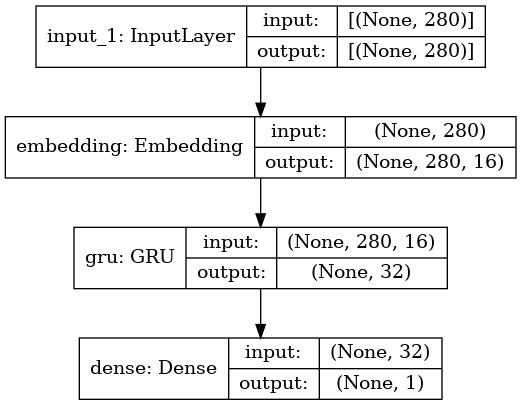

time: 180 ms


In [16]:
plot_model(model, show_shapes=True, to_file=join(folder_path, 'model.png'))

In [17]:
earlyStopCb = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=10)
history = model.fit(padded_X_train, y_train, batch_size=batch_size, epochs=100, validation_split=validation_split, callbacks=[earlyStopCb])

Epoch 1/100
15/15 [==============================] - 6s 214ms/step - loss: 0.6929 - accuracy: 0.4672 - val_loss: 0.6902 - val_accuracy: 0.5088
Epoch 2/100
15/15 [==============================] - 3s 170ms/step - loss: 0.6879 - accuracy: 0.5174 - val_loss: 0.6863 - val_accuracy: 0.5088
Epoch 3/100
15/15 [==============================] - 2s 166ms/step - loss: 0.6796 - accuracy: 0.5265 - val_loss: 0.6753 - val_accuracy: 0.5133
Epoch 4/100
15/15 [==============================] - 3s 169ms/step - loss: 0.6611 - accuracy: 0.5784 - val_loss: 0.6365 - val_accuracy: 0.6681
Epoch 5/100
15/15 [==============================] - 2s 165ms/step - loss: 0.5876 - accuracy: 0.7092 - val_loss: 0.5614 - val_accuracy: 0.7655
Epoch 6/100
15/15 [==============================] - 2s 166ms/step - loss: 0.4615 - accuracy: 0.8761 - val_loss: 0.4742 - val_accuracy: 0.7832
Epoch 7/100
15/15 [==============================] - 2s 164ms/step - loss: 0.3686 - accuracy: 0.8739 - val_loss: 0.4865 - val_accuracy: 0.7876

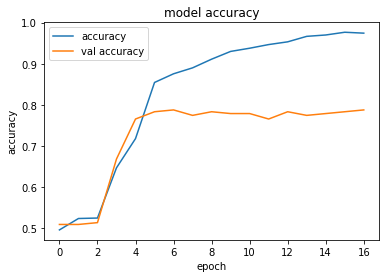

time: 238 ms


In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val accuracy'], loc='upper left')
plt.savefig(join(folder_path, 'history.png'))
plt.show()

## Classification Reports

In [19]:
results = (model.predict(padded_X_test)).round()
report_dict = classification_report(y_test, results, output_dict=True)
report = classification_report(y_test, results)
print(report)
with open(join(folder_path, 'report.json'), 'w') as fp:
    json.dump(report_dict, fp, indent=4)

              precision    recall  f1-score   support

       False       0.61      0.83      0.70       117
        True       0.84      0.62      0.72       165

    accuracy                           0.71       282
   macro avg       0.72      0.73      0.71       282
weighted avg       0.74      0.71      0.71       282

time: 331 ms
